## EDA

### 데이터 명세

- id : 해당 데이터의 고유한 ID (train, test와의 중복은 없음)

- date  : 날짜

- bus_route_id : 노선 id

- in_out  : 시내버스, 시외버스 구분 (categorical)

- station_code : 해당 승하차 정류소의 ID

- station_name : 해당 승하차 정류소의 이름

- latitude : 해당 버스 정류장의 위도 

- longitude : 해당 버스 정류장의 경도 

### *** 같은 위도경도여도 진행 방향에 따라 정류장이 다를수 있음.

- X-Y ride : 00:00부터 59:59까지 승차한 인원수

- X-Y takeoff : 00:00부터 59:59까지 하차한 인원수

- 18-20 ride : 18:00:00부터 19:59:59까지 승차한 인원 수 (train data에만 존재, 예측해야할 target) 


In [1]:
#데이터 처리
import numpy as np 
import pandas as pd 
import datetime

# 결측값 유무 
import missingno as msno 

import warnings #경고 미출력
warnings.filterwarnings('ignore')
from collections import Counter # count

# 시각화
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns 

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
palette = sns.color_palette('twilight') + sns.color_palette('bright')



# 지도 관련 시각화 
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

#데이터 샘플링
import random
from sklearn.preprocessing import LabelEncoder #인코딩
from sklearn.preprocessing import OneHotEncoder

#validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 

#model
import lightgbm as lgbm 

#processing bar
from tqdm import tqdm_notebook

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)
print(test.shape)

(415423, 21)
(228170, 20)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

In [5]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
# target : 18~20_ride
print(train.columns)
print(test.columns)

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')
Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'],
      dtype='object')


In [7]:
print(train.isnull().sum())
print(test.isnull().sum())

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64
id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64


### 18~20 분포

In [8]:
train['18~20_ride'].value_counts().sort_index()

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
          ...  
240.0         1
241.0         1
245.0         1
265.0         1
272.0         1
Name: 18~20_ride, Length: 170, dtype: int64

<AxesSubplot:>

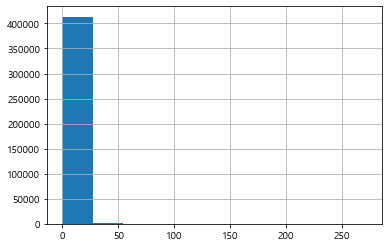

In [9]:
train['18~20_ride'].hist(bins=10)

<AxesSubplot:xlabel='18~20_ride', ylabel='Density'>

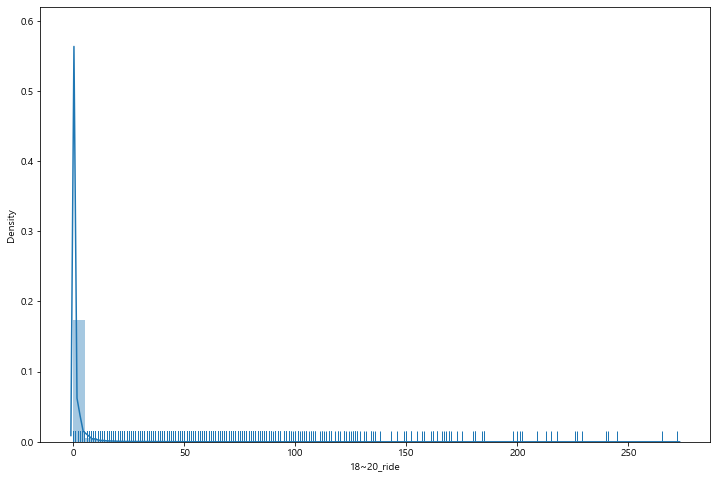

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(train['18~20_ride'], rug=True)

In [19]:
target_col = '18~20_ride'
ride_columns =  [col for col in test.columns if '_ride' in col]
take_off_columns = [col for col in test.columns if '_takeoff' in col]

# Train의 승차 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns].sum(axis=1).agg(['min','max']) )

# Train의 하차 칼럼들의 rowsum
display( train[train[target_col]==0][take_off_columns].sum(axis=1).agg(['min','max']) )

# Train의 승하차 합 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns + take_off_columns].sum(axis=1).agg(['min','max']) ) 

min      0.0
max    138.0
dtype: float64

min      0.0
max    165.0
dtype: float64

min      1.0
max    283.0
dtype: float64

In [20]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### station_name 과 code 다름(방향이 다른 것(2개) 이상)

In [30]:
train.groupby('station_name')['station_code'].nunique().sort_values()

station_name
히귀반석        1
제주자동차검사소    1
제주은행        1
보목신협        1
보목신협앞       1
           ..
조수1리        5
비석거리        6
성읍1리        6
금악리         7
신안동         8
Name: station_code, Length: 1961, dtype: int64

In [40]:
multi_station = train.groupby('station_name')['station_code'].nunique().sort_values()
multi_station[multi_station >= 3]

station_name
신흥동         3
명월리         3
제주대학교병원     3
(구)중앙파출소    3
오등동입구       3
           ..
조수1리        5
비석거리        6
성읍1리        6
금악리         7
신안동         8
Name: station_code, Length: 113, dtype: int64

In [32]:
train[train['station_name']=='금악리']['station_code'].value_counts()

937    77
702    37
942    16
940    10
943     5
939     5
944     4
Name: station_code, dtype: int64

### 요일에 따른 버스 수요

In [45]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [44]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
ride_col_list = ['%d~%d_ride'%(i, i+1) for i in range(6, 12)] + ['18~20_ride']
takeoff_col_list = ['%d~%d_takeoff'%(i, i+1) for i in range(6, 12)] + ['18~20_ride']

In [47]:
df_date_ride = train.groupby(['date']).sum()[ride_col_list].stack().reset_index()
df_date_ride.columns = ['date', 'ride_time', 'count']
df_date_ride['date_disp'] = df_date_ride['date'].apply(lambda x: x[5:])


df_date_takeoff = train.groupby(['date']).sum()[takeoff_col_list].stack().reset_index()
df_date_takeoff.columns = ['date', 'takeoff_time', 'count']
df_date_takeoff['date_disp'] = df_date_takeoff['date'].apply(lambda x: x[5:])
df_date_takeoff.head(5)

,date,takeoff_time,count,date_disp
0,2019-09-01,6~7_takeoff,1343.0,09-01
1,2019-09-01,7~8_takeoff,2713.0,09-01
2,2019-09-01,8~9_takeoff,3671.0,09-01
3,2019-09-01,9~10_takeoff,4077.0,09-01
4,2019-09-01,10~11_takeoff,4510.0,09-01


<AxesSubplot:title={'center':'일별 하차량 증감'}, xlabel='date_disp', ylabel='count'>

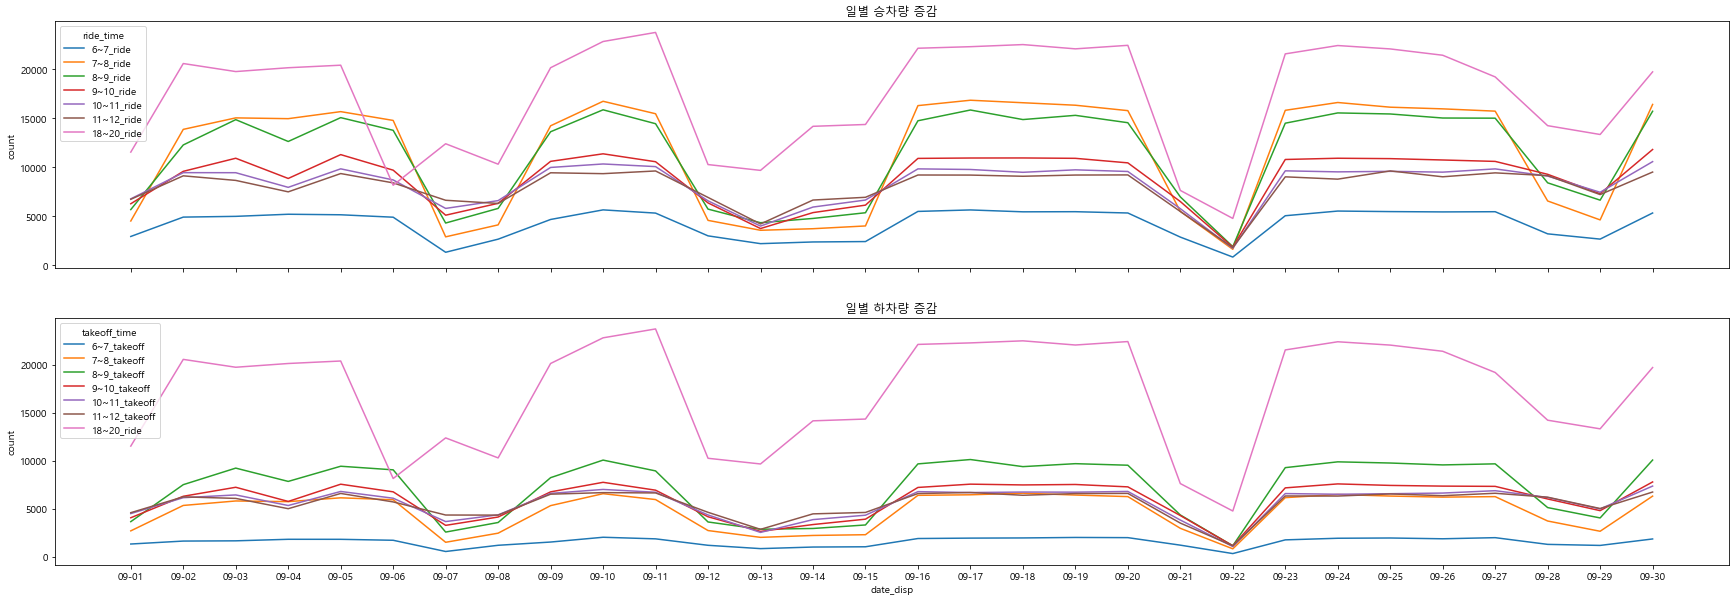

In [48]:
f, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

axes[0].set(title='일별 승차량 증감')
sns.lineplot(x='date_disp', y='count', hue='ride_time', data=df_date_ride, ax=axes[0])

axes[1].set(title='일별 하차량 증감')
sns.lineplot(x='date_disp', y='count', hue='takeoff_time', data=df_date_takeoff, ax=axes[1])

#### 휴일

In [49]:
holidays = ['01-01', '02-04', '02-05', '02-06', '03-01', '05-05', '05-06', '05-12', '06-06', '08-15',
            '09-12', '09-13', '09-14', '10-03', '10-09', '12-25']
holidays = ['2019-'+day for day in holidays]

train['weekday'] = train['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%A"))
train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in ['Saturday', 'Sunday'] else row.holiweekend, axis=1)

In [50]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_week_ride = train.groupby(['weekday']).mean()[ride_col_list[:-1]].stack().reset_index()
df_week_ride.columns = ['weekday', 'ride_time', 'count']

df_week_takeoff = train.groupby(['weekday']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_week_takeoff.columns = ['weekday', 'takeoff_time', 'count']

df_week_ride['order'] = df_week_ride['weekday'].apply(lambda x: weekday_order.index(x))
df_week_ride=df_week_ride.sort_values(by=['order'])

df_week_takeoff['order'] = df_week_takeoff['weekday'].apply(lambda x: weekday_order.index(x))
df_week_takeoff=df_week_takeoff.sort_values(by=['order'])

<AxesSubplot:title={'center':'요일별 하차량 추이'}, xlabel='weekday', ylabel='count'>

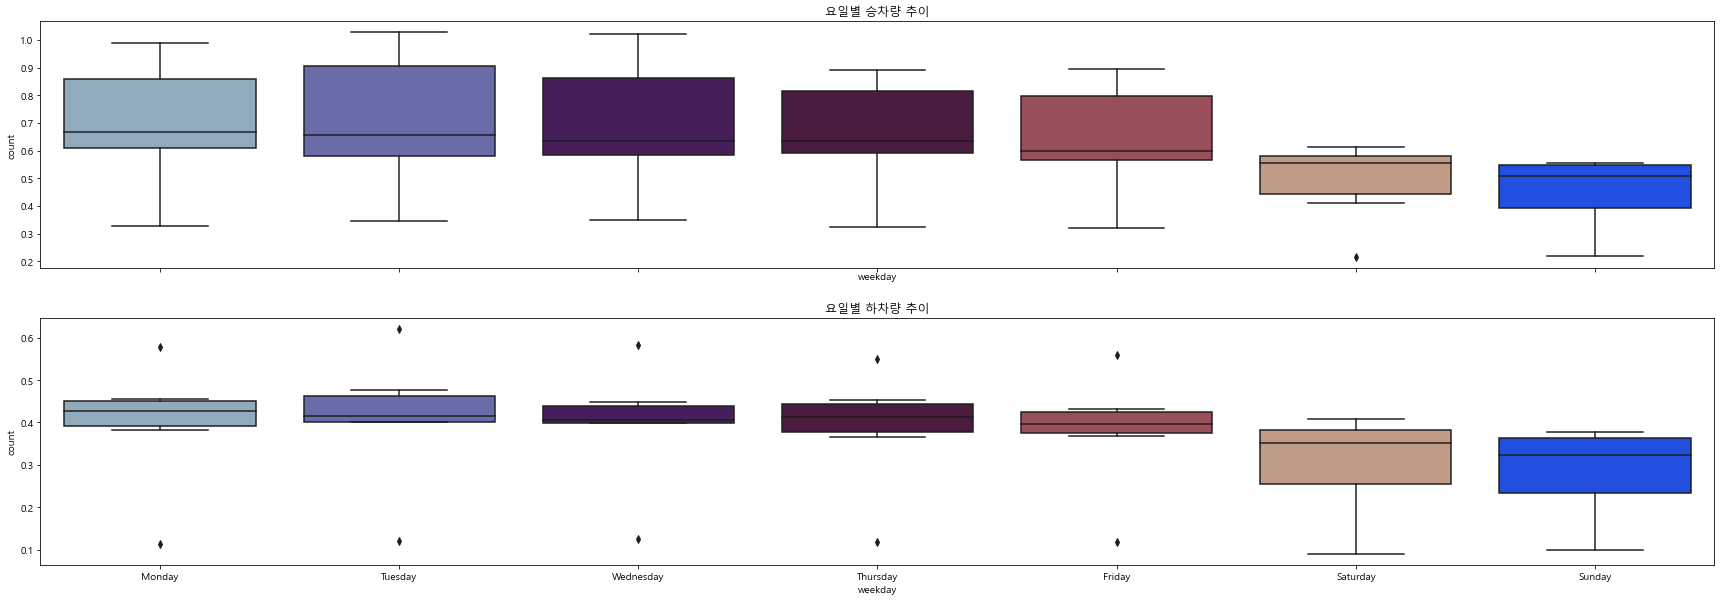

In [51]:
f, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)


axes[0].set(title='요일별 승차량 추이')
axes[1].set(title='요일별 하차량 추이')

sns.boxplot(x='weekday', y='count', data=df_week_ride, ax=axes[0], palette=palette)
sns.boxplot(x='weekday', y='count', data=df_week_takeoff, ax=axes[1], palette=palette)

<AxesSubplot:xlabel='holiweekend', ylabel='count'>

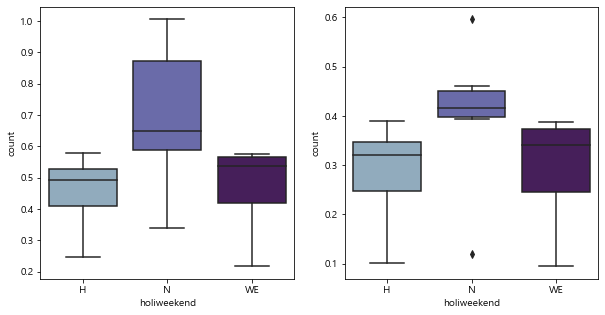

In [52]:
#평일, 휴일 승하차량 비교

f, axes = plt.subplots(1, 2, figsize=(10, 5))

df_holi_ride = train.groupby(['holiweekend']).mean()[ride_col_list[:-1]].stack().reset_index()
df_holi_ride.columns = ['holiweekend', 'ride_time', 'count']

df_holi_takeoff = train.groupby(['holiweekend']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_holi_takeoff.columns = ['holiweekend', 'ride_time', 'count']

sns.boxplot(x='holiweekend', y='count', data=df_holi_ride, ax=axes[0], palette=palette)
sns.boxplot(x='holiweekend', y='count', data=df_holi_takeoff, ax=axes[1], palette=palette)

### 주요 측정소

In [53]:
# 해당 주요 장소의 임의 지역 위도, 경도 (baseline 참조)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [54]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm